# Noise Parameter Scaling

This is an alternative method to canonical noise scaling using the sparse Pauli-Lindblad model discussed by van den Berg et Al. This method takes advantage of the fact that since all of the $\lambda_k(P_k\rho P_k-\rho)$ channels in the Lindbladian commute, the parameters in the noise can be scaled uniformly to achieve an effect similar to canonical noise scaling. This method will be reffered to as parameter scaling.

In [43]:
#helper libraries
import numpy as np
from numpy.random import rand, random
import math
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

#qiskit functionalities
from qiskit import Aer, execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram

#noise model stuff
from qiskit.providers.aer.noise import NoiseModel, kraus_error, pauli_error
    
#operator info
from qiskit.quantum_info import Pauli, Kraus
plt.style.use("ggplot")

Parameters for the model

In [44]:
T = [Pauli("X"), Pauli("Y"), Pauli("Z")] #These are the terms considered in the model
coeffs = [random()*.1 for p in T] #These are the corresponding lambdas
omegas = np.multiply(.5, np.add(1, np.exp(np.multiply(-2.0, coeffs)))) #Equation (S9)
overhead = np.exp(2.0*np.sum(coeffs)) #below Eq (5)

Build the corresponding noise model for use in the simulations

In [45]:
kraus_ops = Kraus(np.identity(2)) #Start with identity map

#Repeatedly compose (w_kI+(1-w_k)P_k) to get error channel as Kraus map
for i in range(len(T)):
    op = Kraus([T[i].to_matrix()*np.sqrt(1-omegas[i]),np.sqrt(omegas[i])*np.identity(2)]);
    kraus_ops = kraus_ops.compose(op);

kraus_error_channel = kraus_error(kraus_ops.data) #create kraus error channel from kraus map
kraus_noise_model = NoiseModel() #create noise model from kraus error channel
kraus_noise_model.add_all_qubit_quantum_error(kraus_error_channel, ['id', 'x', 'y', 'z']) #add noise to all gates
kraus_basis_gates = kraus_noise_model.basis_gates #get noisy basis gates

/home/ben/anaconda3/envs/mitiq/lib/python3.8/site-packages/qiskit/quantum_info/operators/channel/kraus.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if isinstance(data, np.ndarray) or np.array(data).ndim == 2:


## Parameter Scaling

I observed that the Sparse Pauli-Lindblad model gives rise to an intuitive definition of scaled noise by taking $\lambda_k \to \lambda \lambda_k$, where $\lambda \in [0,1]$ is the strength of the noise. Since all the terms in $\mathcal{L}$ are mutually commuting,

$$
e^{\lambda \mathcal{L}(\rho)} = e^{\mathcal{L}(\rho)-\mathcal{L}(\rho)}e^{\lambda \mathcal{L}(\rho)} = \Lambda(\rho) e^{-(1-\lambda)\mathcal{L}(\rho)}
$$

Let 
$$
\Lambda_{(\lambda)}(\rho) \equiv e^{-(1-\lambda)\mathcal{L}(\rho)}
$$

be the map that takes the noise to the desired strength. This map can be expanded into product form as before:

$$
\Lambda_{(\lambda)}(\rho) = \prod_k\frac{1}{2}(e^{2(1-\lambda)\lambda_k}+1)\rho-\frac{1}{2}(e^{2(1-\lambda)\lambda_k}-1)P_k\rho P_k
$$

When $\lambda < 1$, it can be seen that $e^{2(1-\lambda)\lambda_k} > 1$, so the second term is negative. The overhead of the $k^\text{th}$ term is then
$$
\gamma_{(\lambda)}^{(k)} = \frac{1}{2}(e^{2(1-\lambda)\lambda_k}+1)+\frac{1}{2}(e^{2(1-\lambda)\lambda_k}-1) = e^{2(1-\lambda)\lambda_k}
$$
And the total overhead is
$$
\gamma_{(\lambda)} = \prod_{k \in \mathcal{T}} \gamma_{(\lambda)}^{(k)} = e^{2(1-\lambda)\sum_k\lambda_k} = \gamma^{1-\lambda}
$$
The term $\phi_k \equiv \frac{1}{2}(1+e^{-2(1-\lambda)\lambda_k})$ can be used to write the product in quasiprobability form:
$$
\Lambda_{(\lambda)}(\rho) = \gamma_{(\lambda)}\prod_{k\in\mathcal{T}} \phi_k \rho-(1-\phi_k)P_k\rho P_k
$$
The sampling can be accomplished with the same procedure as the inverse map. In the case where $\lambda > 1$, then the second term in the sum is positive, and the product is already a probability distribution with overhead $1$.

There is no natural limit to the scaling of this noise above hardware level. The largest error probability is
$$
\prod_k \frac{1}{2}(1-e^{-2(\lambda-1)\lambda_k}) < \left(\frac{1-e^{-2(\lambda-1)\lambda_{min}}}{2}\right)^k <1
$$
Since $e^{-2(\lambda-1)\lambda_{min}}\leq 1$ for all $\lambda_{min}$, there is no upper bound on $\lambda$.

In [46]:
samples = 1000
shots = 100
total = 0

#Follow the procedure for sampling gates
def uniform_noise_scaling(lmbda, samples, gate_to_mitigate):
    
    total = 0 #store the estimator
    phis = .5*(np.exp(np.multiply(-2.0*np.abs(1-lmbda), coeffs))+1) #new adjusted coefficients
    
    if(lmbda < 1):
        gamma = overhead**(1-lmbda) #new overhead
    else:
        gamma = 1
    
    backend = Aer.get_backend('qasm_simulator') #getting closer to this being a real QPU
    
    for i in range(samples):
        m = 1 #store the sign
        op = gate_to_mitigate #start with the target gate
        for (phi, Pk) in zip(phis, T):
            if rand() < 1-phi: #sample the pauli with prob 1-phi
                m*=-1
                op = op.compose(Pk)
                
        qc = QuantumCircuit(1,1) 
        qc.append(op.to_instruction(),[0]) #apply combination of paulis in circuit
        qc.measure(0,0)
        
        if(lmbda > 1): #no sign adjustments if noise is being scaled up
            m = 1
        
        #run one shot of this circuit
        counts = execute(qc, backend, noise_model=kraus_noise_model, 
                        basis_gates = kraus_basis_gates, shots = shots,
                        optimization_level = 0).result().get_counts()
        
        total += (counts.get('0',0)-counts.get('1',0))*m/shots #update estimator
    
    return total*gamma/samples 

## Uniform scaling test

Testing the uniform scaling method for different strengths of noise

In [47]:
lmbdas = [0, .33, .66, 1, 1.33]
mitigated_values_scaling = []
samples = 4096
#Run the procedure for each lambda
for lmbda in lmbdas:
    mitigated_value = uniform_noise_scaling(lmbda, samples, Pauli('X'))
    mitigated_values_scaling.append(mitigated_value)
    
#get unmitigated value
qc = QuantumCircuit(1,1)
qc.x(0)
qc.measure(0,0)
backend = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend, noise_model=kraus_noise_model, 
                        basis_gates = kraus_basis_gates, shots = samples,
                        optimization_level = 0).result().get_counts()

unmitigated_value = (counts.get('0',0)-counts.get('1',0))/samples

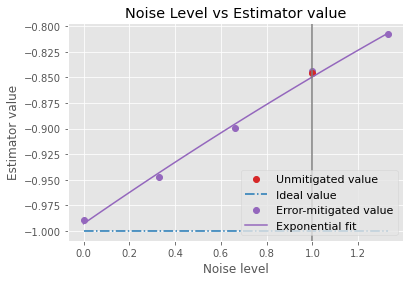

In [48]:
xrange = np.linspace(0, max(lmbdas), 100)
mvs, = plt.plot(lmbdas, mitigated_values_scaling, marker = 'o', linestyle = "None",color = "tab:purple")
iv, = plt.plot(xrange, [-1]*len(xrange), linestyle = '-.',color = "tab:blue")
umv, = plt.plot(1, unmitigated_value, marker = 'o', linestyle = "None", color = "tab:red")
expfit = lambda x,a,b : -a*np.exp(-b*x)
popt,pcov = curve_fit(expfit, lmbdas, mitigated_values_scaling)
fit, = plt.plot(xrange, [expfit(x, *popt) for x in xrange], color = "tab:purple")
plt.xlabel("Noise level")
plt.ylabel("Estimator value")
plt.axvline(1, color = "tab:gray")
plt.title("Noise Level vs Estimator value")
plt.legend([umv, iv, mvs, fit], ['Unmitigated value','Ideal value','Error-mitigated value','Exponential fit'], loc="lower right", prop = {"size":11})

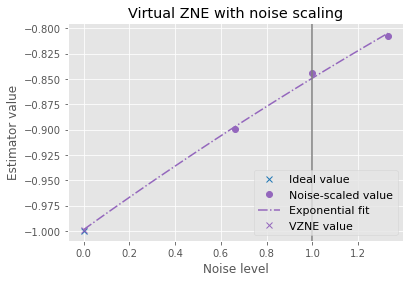

In [49]:
N = 3
xrange = np.linspace(0, max(lmbdas), 100)
mvs, = plt.plot(lmbdas[-N:], mitigated_values_scaling[-N:], marker = 'o', linestyle = "None",color = "tab:purple")
iv, = plt.plot(0, -1, linestyle = "None", marker = 'x',color = "tab:blue")
expfit = lambda x,a,b : -a*np.exp(-b*x)
popt,pcov = curve_fit(expfit, lmbdas[-N:], mitigated_values_scaling[-N:])
fit, = plt.plot(xrange, [expfit(x, *popt) for x in xrange], color = "tab:purple", linestyle="-.")
exval, = plt.plot(0,expfit(0, *popt),linestyle = "None",color="tab:purple", marker = "x")
plt.xlabel("Noise level")
plt.ylabel("Estimator value")
plt.axvline(1, color = "tab:gray")
plt.title("Virtual ZNE with noise scaling")
plt.legend([iv, mvs, fit, exval], ['Ideal value','Noise-scaled value','Exponential fit', 'VZNE value'], loc="lower right", prop = {"size":11})